In [1]:
from __future__ import annotations
from abc import ABC, abstractmethod
import pandas as pd
import numpy as np
from sklearn import metrics,linear_model
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

FILE = 'data'
listErrors = {}


In [2]:
def plotResults(errors: dict):
    plt.figure(figsize=(20, 3))
    plt.bar(*zip(*errors.items()))
    plt.show()


# Obtención de datos

In [3]:
data = pd.read_csv('%s/winequality-white-missing.csv' %FILE, sep=";")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4400 non-null   float64
 1   volatile acidity      4431 non-null   float64
 2   citric acid           4411 non-null   float64
 3   residual sugar        4434 non-null   float64
 4   chlorides             4387 non-null   float64
 5   free sulfur dioxide   4398 non-null   float64
 6   total sulfur dioxide  4429 non-null   float64
 7   density               4413 non-null   float64
 8   pH                    4415 non-null   float64
 9   sulphates             4372 non-null   float64
 10  alcohol               4412 non-null   float64
 11  quality               4898 non-null   float64
dtypes: float64(12)
memory usage: 459.3 KB


In [4]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4400.000000,4431.000000,4411.000000,4434.000000,4387.000000,4398.000000,4429.000000,4413.000000,4415.000000,4372.000000,4412.000000,4898.000000
mean,6.849080,0.277857,0.334670,6.393223,0.046018,35.394839,137.756266,0.994038,3.188061,0.489879,10.518351,5.877909
std,0.835875,0.100151,0.122274,5.086485,0.022396,17.092922,42.078770,0.003014,0.151680,0.114343,1.234730,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.740000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991740,3.080000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993800,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.850000,0.050000,46.000000,166.000000,0.996120,3.280000,0.550000,11.400000,6.000000
max,11.800000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [5]:
originalData = pd.read_csv('%s/winequality-white.csv' %FILE, sep=";")
originalData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [6]:
originalData.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [8]:
def getError(tableA, tableB, keys):
    errors = { key:metrics.mean_squared_error(
        tableA.loc[positionalLostValues, key], 
        tableB.loc[positionalLostValues, key]
    ) for key in keys}
    return errors
getError(originalData, originalData,data.keys()[:-1])

{'fixed acidity': 0.0,
 'volatile acidity': 0.0,
 'citric acid': 0.0,
 'residual sugar': 0.0,
 'chlorides': 0.0,
 'free sulfur dioxide': 0.0,
 'total sulfur dioxide': 0.0,
 'density': 0.0,
 'pH': 0.0,
 'sulphates': 0.0,
 'alcohol': 0.0}

In [9]:
class Column():
    def __init__(self, key:str,positionalLostValues:pd.Series,index:int):
       self.key = key
       self.positionalLostValues = positionalLostValues
       self.index = index


In [10]:
def getColumnsWithNulls(df: pd.DataFrame) -> list:
    return [
        Column(key, data[key].isnull(), idx) for idx,key in enumerate(df)
        if any(data[key].isnull())
    ]
print(getColumnsWithNulls(data)[0].index)

0


In [11]:
def meanImputation(meanImputationData: pd.DataFrame, columnsNulls: list) -> None:
    for col in columnsNulls:
        meanImputationData.loc[col.positionalLostValues, col.key] = meanImputationData.loc[~col.positionalLostValues, col.key].mean()

## Imputación MICE

In [12]:
def LinearImputation(LinearImputationData: pd.DataFrame, colum: Column):
    matLost = LinearImputationData[colum.positionalLostValues].values
    matNotLost = LinearImputationData[~colum.positionalLostValues].values
    listIndex = list(range(len(LinearImputationData.keys())-1))
    listIndex.remove(colum.index)
    xLost = matLost[:,listIndex]
    x = matNotLost[:, listIndex]
    yHat = matNotLost[:,colum.index]
    model = linear_model.LinearRegression()
    model.fit(x,yHat)
    LinearImputationData.loc[colum.positionalLostValues, colum.key] = model.predict(xLost)

In [13]:
def miceImputation(df:pd.DataFrame, iters: int) -> pd.DataFrame:
    miceImputationData = df.copy()
    columnsNulls = getColumnsWithNulls(miceImputationData)
    meanImputation(miceImputationData, columnsNulls)
    for _ in range(iters):
        for col in columnsNulls:
            LinearImputation(miceImputationData, col)
    return miceImputationData

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   float64
dtypes: float64(12)
memory usage: 459.3 KB
None
####
{'fixed acidity': 0.04284913394951465, 'volatile acidity': 0.0008411670307475367, 'citric acid': 0.0007671383290380138, 'resid

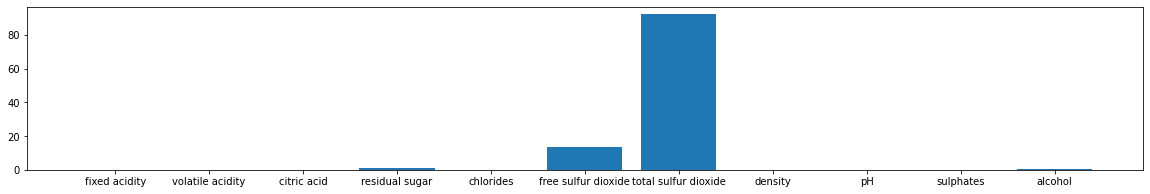

In [14]:
result = miceImputation(data, 100)
print(result.info())
err = getError(result, originalData, data.keys()[:-1])
print("####")
print(err)
plotResults(err)

## Imputación mediante HOT-DECK

In [17]:
def calculateIndicesToSubstitute(hotDeckImputationData: pd.DataFrame, colum: Column):
    matLost = hotDeckImputationData[colum.positionalLostValues].values
    matNotLost = hotDeckImputationData[~colum.positionalLostValues].values
    listIndex = list(range(len(hotDeckImputationData.keys())-1))
    listIndex.remove(colum.index)
    dfLostValues = matLost[:,listIndex]
    dfValues = matNotLost[:, listIndex]

    euclidianDistances = [
        [np.linalg.norm(vecLost-vecValues) for vecValues in dfValues]
        for vecLost in dfLostValues
    ]
    return [ np.where(vecDists == np.amin(vecDists))[0][0] for vecDists in euclidianDistances]


In [18]:
def hotDeck(df: pd.DataFrame):
    hotDeckImputationData = df.copy()
    columnsNulls = getColumnsWithNulls(hotDeckImputationData)
    meanImputation(hotDeckImputationData, columnsNulls)
    for col in columnsNulls:
        hotDeckImputationData.loc[col.positionalLostValues, col.key] = hotDeckImputationData[col.key][
            calculateIndicesToSubstitute(hotDeckImputationData, col)].values
    return hotDeckImputationData

In [19]:
df = hotDeck(data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   float64
dtypes: float64(12)
memory usage: 459.3 KB


{'fixed acidity': 0.155981763172019, 'volatile acidity': 0.0014598775930125137, 'citric acid': 0.0023678476949745677, 'residual sugar': 4.540383026002262, 'chlorides': 0.00010108931388927513, 'free sulfur dioxide': 39.38296382255541, 'total sulfur dioxide': 361.22695049747165, 'density': 9.269492295129484e-07, 'pH': 0.003226733024136503, 'sulphates': 0.004276644298712211, 'alcohol': 2.83861440709005}


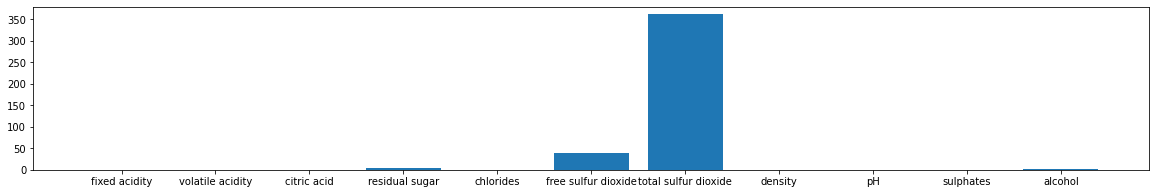

In [20]:
err = getError(df, originalData, data.keys()[:-1])
print(err)
plotResults(err)